<a href="https://colab.research.google.com/github/ShambhaviSingh17/Lung-Abnormality-Detection-/blob/main/Cliniscan17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CliniScan:Lung-Abnormality Detection on Chest X‑rays using AI**

**1-DICOM to PNG Conversion Utility**

In [26]:
# Install dependencies
%pip install pydicom

import os
import cv2
import pydicom
import pandas as pd


def dicom_to_png(dicom_path: str, png_path: str) -> bool:
    """Convert a single DICOM file to PNG format."""
    try:
        ds = pydicom.dcmread(dicom_path)
        img = ds.pixel_array

        # Normalize pixel values to 0–255 and convert to uint8
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_norm.astype("uint8")

        cv2.imwrite(png_path, img_uint8)
        return True
    except Exception as e:
        print(f"❌ Failed to convert {dicom_path}: {e}")
        return False


def convert_dataset(dicom_dir: str, output_dir: str, annotations_csv: str):
    """Batch convert DICOM dataset to PNG using annotations."""
    os.makedirs(output_dir, exist_ok=True)
    annotations = pd.read_csv(annotations_csv)

    for _, row in annotations.iterrows():
        dicom_file = os.path.join(dicom_dir, f"{row['image_id']}.dicom")
        png_file = os.path.join(output_dir, f"{row['image_id']}.png")

        if os.path.exists(dicom_file):
            if dicom_to_png(dicom_file, png_file):
                print(f"✅ Converted: {dicom_file} → {png_file}")
        else:
            print(f"⚠️ Missing file: {dicom_file}")


**2-Custom Dataset Class (VinDr-CXR)**

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import cv2
from PIL import Image

class VinDrCXRDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, task='classification'):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.task = task

        self.labels = sorted(df['label'].unique())
        self.label_to_id = {label: i for i, label in enumerate(self.labels)}

        self.grouped_images = self.df.groupby('image_id')
        self.image_ids = list(self.grouped_images.groups.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        annotations = self.grouped_images.get_group(img_id)

        if self.task == 'classification':
            label_vector = torch.zeros(len(self.labels), dtype=torch.float)
            for _, row in annotations.iterrows():
                label_vector[self.label_to_id[row['label']]] = 1.0

            if self.transform:
                image = self.transform(image)

            return image, label_vector

        elif self.task == 'detection':
            boxes, labels = [], []
            for _, row in annotations.iterrows():
                boxes.append([row['x_min'], row['y_min'], row['x_max'], row['y_max']])
                labels.append(self.label_to_id[row['label']])

            target = {
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64)
            }

            if self.transform:
                image = self.transform(image)

            return image, target


**3-ResNet18 Classifier (Transfer Learning)**

In [29]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # Load a pre-trained ResNet-18 model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        # Modify the final fully connected layer for your number of classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

if __name__ == "__main__":
    num_classes = 5 # Example number of classes
    model = ResNetClassifier(num_classes)

    # Check model output
    dummy_input = torch.randn(1, 3, 256, 256)
    output = model(dummy_input)
    print(f"Model output shape: {output.shape}")

Model output shape: torch.Size([1, 5])


**4.Google Drive Mount & Dataset Extraction**

In [30]:
import zipfile, os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

zip_path = "/content/drive/MyDrive/ColabDatasets/archive(3).zip"
extract_path = "/content/dataset"

# Extract dataset if not already extracted
if not os.path.exists(extract_path) or not os.listdir(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Dataset extracted to: {extract_path}")
else:
    print(f"ℹ️ Dataset already exists at: {extract_path}")

# Show dataset structure (first 40 lines)
print("📂 Dataset structure (first 40 lines):")
!ls -R /content/dataset | head -40


Mounted at /content/drive
ℹ️ Dataset already exists at: /content/dataset
📂 Dataset structure (first 40 lines):
/content/dataset:
chest_xray
train
val

/content/dataset/chest_xray:
chest_xray
__MACOSX
test
train
val

/content/dataset/chest_xray/chest_xray:
test
train
train.cache
val
val.cache

/content/dataset/chest_xray/chest_xray/test:
NORMAL
PNEUMONIA

/content/dataset/chest_xray/chest_xray/test/NORMAL:
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
IM-0009-0001.jpeg
IM-0010-0001.jpeg
IM-0011-0001-0001.jpeg
IM-0011-0001-0002.jpeg
IM-0011-0001.jpeg
IM-0013-0001.jpeg
IM-0015-0001.jpeg
IM-0016-0001.jpeg
IM-0017-0001.jpeg
IM-0019-0001.jpeg
IM-0021-0001.jpeg


**5-YOLOv8 Setup, Dataset Preparation & Training**

In [31]:
# Install YOLOv8
!pip install ultralytics --quiet

import os
import random
import torch
import zipfile
import shutil
from ultralytics import YOLO
from google.colab import drive

# Check PyTorch & GPU
print("✅ Torch version:", torch.__version__)
print("✅ GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✅ GPU name:", torch.cuda.get_device_name(0))

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Dataset paths
zip_path = "/content/drive/MyDrive/ColabDatasets/archive(3).zip"
extract_path = "/content/dataset"

# Extract dataset if not already extracted
if not os.path.exists(extract_path) or not os.listdir(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Dataset extracted to {extract_path}")
else:
    print("ℹ️ Dataset already available.")

# Reorganize dataset for YOLOv8 classification (example: single class 'cat')
train_dir = os.path.join(extract_path, "train")
val_dir = os.path.join(extract_path, "val")

cat_train_dir = os.path.join(train_dir, "cat")
os.makedirs(cat_train_dir, exist_ok=True)

# Move all training images into class folder
for f in os.listdir(train_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.move(os.path.join(train_dir, f), os.path.join(cat_train_dir, f))

# Create validation directory and subfolder
os.makedirs(val_dir, exist_ok=True)
cat_val_dir = os.path.join(val_dir, "cat")
os.makedirs(cat_val_dir, exist_ok=True)

# Split 10% of data into validation
images = os.listdir(cat_train_dir)
random.shuffle(images)
num_val = max(1, int(0.1 * len(images)))

for img in images[:num_val]:
    shutil.move(os.path.join(cat_train_dir, img), os.path.join(cat_val_dir, img))

print("✅ Dataset reorganized for YOLOv8 classification.")

# Show dataset structure (first 40 lines)
!ls -R /content/dataset | head -40

# Load pretrained YOLOv8 classification model
model = YOLO("yolov8n-cls.pt")

# Train the model
model.train(
    data="/content/dataset/chest_xray/chest_xray",  # path with train/ and val/
    epochs=20,
    imgsz=224,
    batch=32,
    name="classification_model_fixed"
)


✅ Torch version: 2.8.0+cu126
✅ GPU available: True
✅ GPU name: Tesla T4
Mounted at /content/drive
ℹ️ Dataset already available.
✅ Dataset reorganized for YOLOv8 classification.
/content/dataset:
chest_xray
train
val

/content/dataset/chest_xray:
chest_xray
__MACOSX
test
train
val

/content/dataset/chest_xray/chest_xray:
test
train
train.cache
val
val.cache

/content/dataset/chest_xray/chest_xray/test:
NORMAL
PNEUMONIA

/content/dataset/chest_xray/chest_xray/test/NORMAL:
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg
IM-0006-0001.jpeg
IM-0007-0001.jpeg
IM-0009-0001.jpeg
IM-0010-0001.jpeg
IM-0011-0001-0001.jpeg
IM-0011-0001-0002.jpeg
IM-0011-0001.jpeg
IM-0013-0001.jpeg
IM-0015-0001.jpeg
IM-0016-0001.jpeg
IM-0017-0001.jpeg
IM-0019-0001.jpeg
IM-0021-0001.jpeg
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classe

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e98f5746480>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('/content/runs/classify/classification_model_fixed2')
speed: {'preprocess': 0.10297074999243705, 'inference': 0.5783203749842869, 'loss': 0.0005632500119645556, 'postprocess': 0.000730500005374779}
task: 'classify'
top1: 1.0
top5: 1.0

**6-Grad-CAM Setup & Visualization**

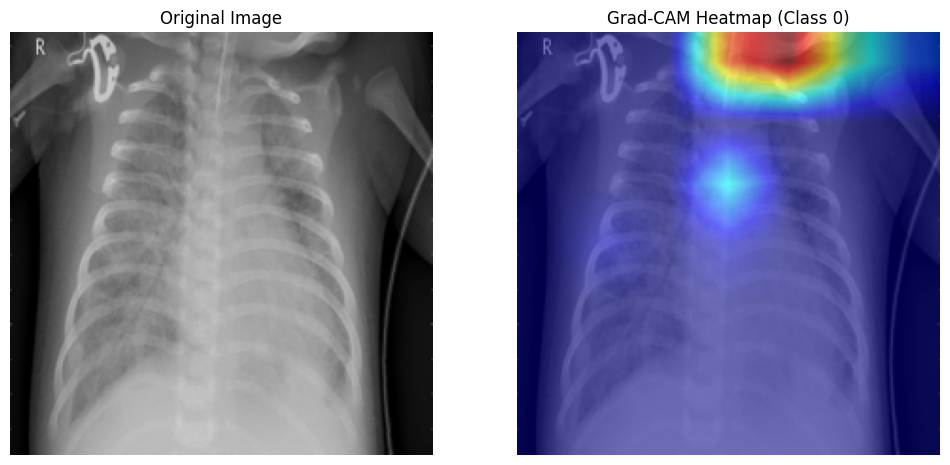

Predicted class: NORMAL (50.04%)


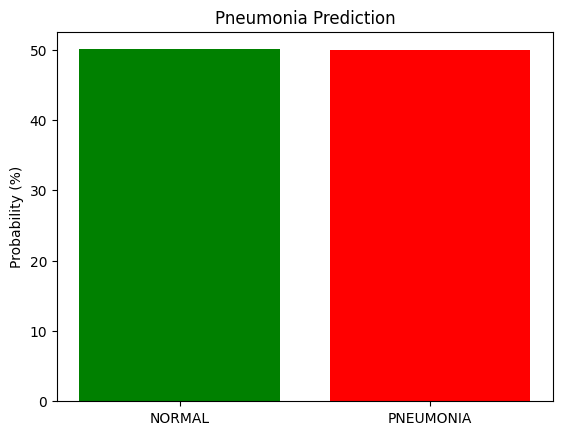

('NORMAL', 50.04270672798157)

In [37]:
# ================================================================
# Grad-CAM Setup & Visualization
# ================================================================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from __main__ import ResNetClassifier  # adjust import if needed

# Config
num_classes = 2  # NORMAL, PNEUMONIA
class_names = ["NORMAL", "PNEUMONIA"]

# Example image
IMAGE_PATH = "/content/dataset/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"

# Load model
model = ResNetClassifier(num_classes)
# model.load_state_dict(torch.load("model.pth", map_location="cpu"))
model.eval()

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Grad-CAM visualization
img = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = transform(img).unsqueeze(0)
rgb_img = np.array(img.resize((224, 224))) / 255.0

target_layers = [model.model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = torch.argmax(outputs, dim=1).item()

grayscale_cam = cam(input_tensor=input_tensor,
                    targets=[ClassifierOutputTarget(pred_class)])[0]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Plot original image + Grad-CAM heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(rgb_img)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(visualization)
ax2.set_title(f"Grad-CAM Heatmap (Class {pred_class})")
ax2.axis("off")

plt.show()


# ================================================================
# X-ray Prediction Function (with Probabilities)
# ================================================================
def predict_xray(image_path):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)[0]

    pred_class = torch.argmax(probs).item()
    confidence = probs[pred_class].item() * 100

    print(f"Predicted class: {class_names[pred_class]} ({confidence:.2f}%)")

    plt.bar(class_names, probs.numpy() * 100, color=["green", "red"])
    plt.ylabel("Probability (%)")
    plt.title("Pneumonia Prediction")
    plt.show()

    return class_names[pred_class], confidence

predict_xray(IMAGE_PATH)


**7-Deployment**

In [34]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import subprocess
import threading
import time
import os
from pyngrok import ngrok, conf

# ================================================================
# Deployment Setup (Streamlit + ngrok)
# ================================================================
STREAMLIT_PORT = 8501
NGROK_AUTH_TOKEN = "YOUR_NGROK_AUTH_TOKEN"  # Replace with your token

def start_streamlit_process():
    """Run Streamlit app as background process."""
    cmd = ["streamlit", "run", "app.py", "--server.port", str(STREAMLIT_PORT), "--server.headless=True"]
    proc = subprocess.Popen(cmd)
    return proc

def start_ngrok_tunnel(port):
    """Create ngrok tunnel for given port."""
    try:
        if NGROK_AUTH_TOKEN == "YOUR_NGROK_AUTH_TOKEN":
            print("\n--- NGROK SETUP FAILED ---")
            print("Set your ngrok auth token in NGROK_AUTH_TOKEN.")
            return None
        conf.get_default().auth_token = NGROK_AUTH_TOKEN
        public_url = ngrok.connect(port, proto="http")
        return public_url
    except Exception as e:
        print(f"Failed to start ngrok tunnel: {e}")
        return None

# Run deployment if not already in Streamlit
if "RUNNING_IN_STREAMLIT" not in os.environ:
    os.environ["RUNNING_IN_STREAMLIT"] = "true"
    print("\n--- Starting Deployment ---")

    threading.Thread(target=start_streamlit_process).start()
    time.sleep(5)  # wait for Streamlit
    public_url = start_ngrok_tunnel(STREAMLIT_PORT)

    if public_url:
        print("\n--- APP DEPLOYED ---")
        print(f"Public URL: {public_url}\n")
        print("Press Ctrl+C to stop.")

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("\nShutting down...")
        ngrok.kill()
        print("Done.")
    st.stop()

# ================================================================
# Streamlit App Logic
# ================================================================

# --- Load Model ---
@st.cache_resource
def load_model():
    """Load trained model or dummy ResNet."""
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2)
    try:
        model.load_state_dict(torch.load("model.pth", map_location="cpu"))
        st.success("Trained model loaded.")
    except FileNotFoundError:
        st.warning("`model.pth` not found. Using dummy model.")
    model.eval()
    return model

model = load_model()

# --- Preprocessing ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- User Interface ---
st.title("🩻 Chest X-Ray Classification")
st.write("Upload a Chest X-ray image for classification.")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    try:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Uploaded Image", use_column_width=True)

        input_tensor = transform(image).unsqueeze(0)
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1)[0]
            pred_class = torch.argmax(probs).item()

        class_names = ["Normal", "Pneumonia"]
        st.write(f"### Prediction: **{class_names[pred_class]}**")
        st.write(f"Confidence: {probs[pred_class].item()*100:.2f}%")
        st.bar_chart({class_names[i]: probs[i].item() for i in range(len(class_names))})
    except Exception as e:
        st.error(f"Prediction error: {e}")


Overwriting app.py


In [35]:
!python app.py

Traceback (most recent call last):
  File "/content/app.py", line 1, in <module>
    import streamlit as st
ModuleNotFoundError: No module named 'streamlit'
